# 타이타닉 생존자 예측

## 목차
1. 문제인식
2. 데이터 정비  
    2-1 변수설명  
    2-2 4가지 Data Cleaning  
    2-3 Train_Test_Split
3. EDA with statistics  
    3-1 다양한 그래프를 이용하여 변수들과 Survived의 관계파악
    

## 1. 문제 인식
* RMS 타이타닉호는 역사상 악명 높은 난파선 중 하나이며 1912년 4월 15일 타이타닉호는 빙산과 충돌한 후 침몰하여 2224명 중 1502명이 사망했다.
* 난파선이 이런 인명피해를 낸 이유 중 하나는 구명보트가 부족했기 때문이었다. 침몰에서 살아남는데 행운의 요소가 어느 정도 포함되었지만 여성, 아동, 상ㄹ류층 등 다른 집단보다 생존 가능성이 더 높은 집단이 있었다.
* 이번 challenge에서는 어떤 종류 혹은 집단의 사람들이 살아남을 것 같았는지 부석을 하는 것이다. 특히 이 참사에서 살아남은 승객이 누구인지 예측하기 위해서 Machine Learning을 사용하여 예측해보도록 한다.
* **이번 문제는 생존을 했는지 안했는지를 예측하는 문제로 binary classification문제롤 접근하였다.**

**Note :** 이번 challenge는 Kaggle에서 주어지는 꽤나 깔끔한 데이터를 사용하였으며 감사하게도 Data architecture, governance, and extraction과 같은 처리는 해주지 않았으며 Data cleaning 위주로 진행하였다.

In [1]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import IPython
import sklearn
import matplotlib

import random
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble,\
 discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8

## 2. 데이터 준비

### 2-1. 변수설명
* 먼저, 이름을 통해 데이터를 파악하고 데이터에 대하여 자세히 알아보도록 한다. (예를 들어, 데이터의 타입이 어떻게 생겼는지 혹은 독립형 변수인지 의존형 변수인지를 알아본다.)

1. Survived : 생존한 것이 1, 생존하지 못한 것이 0, 이진 데이터.
2. PassengerID : 결과에 영향을 미치지 않는 고유식별자. 분석에서 사용하지 않는다.
3. Pclass : 순서형 데이터. 사회경제적 지위를 나타내며 (1:상위, 2:중간, 3:하위)를 나타낸다.
4. Name : 명목형 변수로, 이 변수는 feature engineering을 통해 가족크기 혹은 지위에 대한 타이틀을 도출할 수 있다. 
5. Sex & Embarked : 성별과 탑승위치는 명목형 데이터로 dummy 변수로 변환시켜 사용하도록 한다.
6. Age & Fare : 나이와 요금은 연속형 양적 데이터이다.
7. SibSp & Parch: 탑승자의 형제 자매수, 부모자녀수를 나타낸다. 둘다 이산적 quantitative 데이터이다. 가족의 크기를 만들 때 사용할 수 있으며, 가변적이다.
8. Cabin : 사고가 발생했을 때 선박의 대략적인 위치를 나타낸다. Null값이 많기 때문에 사용하지 않기로 한다.

In [11]:
data_raw = pd.read_csv('../data/titanic/train.csv')
data_val = pd.read_csv('../data/titanic/test.csv')

data1 = data_raw.copy()
data_cleaner = [data1, data_val]

print(data_raw.info())
data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.0000,NaN,S
686,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,31.0000,NaN,C
107,108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S
253,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.1000,NaN,S
712,713,1,1,"Taylor, Mr. Elmer Zebley",male,48.0,1,0,19996,52.0000,C126,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S


### 2-2. 4가지 Data Cleaning : Correcting, Completing, Creating, Converting

* **Correcting** : 이상치 및 특이치 수정. **데이터 검토**를 통해 잘못된 데이터나 허용되지 않는 데이터가 있는지 확인(현재 데이터에서는 없는 것으로 나타난다.) 수정의 경우 분명히 나이나 요금처럼 특이치를 가질 것으로 보이는 column이 있지만 성급히 수정하지 않고 EDA를 하고나서 확인한 후 수정하도록 한다.
* **Completing** : Missing 정보 완성. 보통 Missing Value를 채우는 것으로써는 **삭제** 혹은 **합리적인 입력값 입력**이 있다. **(질적데이터 : mode, 정량데이터 : mean 혹은 mid 혹은 mean + 표준편차)** 일단은 기본적은 방법으로 결측값을 채우도록 한다. 물론 더 복잡한 방법이 있지만 기본적인 방법으로 결측값을 채운 후에 분석을 진행한 후 정확도를 높이기 위해서 수정하도록 한다.
* **Creating** : 새로운 feature 만들기. 기존 feature를 사용하여 새로운 feature를 만든다.
* **Converting** : 데이터 정리. 현 데이터는 범주형 데이터로 되어있어 수학적 계산하기 어렵기 때문에 dummy변수로 변환하여 계산을 해주도록 한다.

In [12]:
print('Train columns with null values : \n',
      data1.isnull().sum())
print('-'*40)

print('Test/Validation columns with null values : \n',
      data_val.isnull().sum())
print('-'*40)

data_raw.describe(include = 'all')

Train columns with null values : 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------
Test/Validation columns with null values : 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------------------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Uruchurtu, Don. Manuel E",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


#### Completing : 결측치 처리
* Age : 중앙값으로 처리
* Embarked : 최빈값으로 처리
* Fare : 중앙값으로 처리
* Cabin & Ticket : drop 처리

In [13]:
data1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [14]:
for dataset in data_cleaner :
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
drop_column = ['PassengerId', 'Cabin', 'Ticket']
data1.drop(drop_column, axis = 1, inplace = True)
    
print(data1.isnull().sum())
print('-'*40)
print(data_val.isnull().sum())                    

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


#### Creating : 새로운 변수 만들기 
* FamilySize : '형제자매수 + 부모자녀수 + 나'로 계산하여 가족의 크기를 게산한다.
* IsAlone : 가족수가 1명이면 1 아니면 0으로 표현한다.
* Title : 'Name'변수로 부터 ['Mr', 'Mrs', 'Miss']와 같은 title을 가져와 새로운 변수로 만들어준다.
    * Title의 경우 10개보다 적은 Title은 Misc로 통일시켜준다.
* FareBin : 'Fare'변수를 4분위수로 나뉘어 4분할된 값을 새로운 변수로 가진다.
* AgeBin : 'Age'변수를 5분위로 나뉘어 5분할된 값을 새로운 변수로 가진다.

In [16]:
data1['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [18]:
for dataset in data_cleaner :
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    
    dataset['Title'] = dataset['Name'].str.split(", ", expand = True)[1].str.split('.', expand = True)[0]
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    

title_names = (data1['Title'].value_counts() < 10)
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print('-'*40)

data1.info()
data_val.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null objec

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
156,1,3,"Gilnagh, Miss. Katherine ""Katie""",female,16.00,0,0,7.7333,Q,1,1,Miss,"(-0.001, 7.91]","(-0.08, 16.0]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
168,0,1,"Baumann, Mr. John D",male,28.00,0,0,25.9250,S,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
519,0,3,"Pavlovic, Mr. Stefo",male,32.00,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0,0,80.0000,S,1,1,Mrs,"(31.0, 512.329]","(48.0, 64.0]"
522,0,3,"Lahoud, Mr. Sarkis",male,28.00,0,0,7.2250,C,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
451,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,28.00,1,0,19.9667,S,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
139,0,1,"Giglio, Mr. Victor",male,24.00,0,0,79.2000,C,1,1,Mr,"(31.0, 512.329]","(16.0, 32.0]"
78,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,29.0000,S,3,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
466,0,2,"Campbell, Mr. William",male,28.00,0,0,0.0000,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"


#### Converting : 원핫인코딩을 이용한 dummy변수로 변환
* Sex, Embarked, Title, AgeBin, FareBIn을 dummy변수로 변환한다.
* data1_x는 원래의 데이터를 가져온다.
* data1_x_calc는 원래데이터(성별과 Embarked는 labeling된 채로 가져온다.
* data1_x_bin은 연속형 데이터를 feature engineering한 데이터이다.
* data1_dummy는 원래데이터에서 주어진 column명에 대하여 one-hot encoding한 데이터이다.

In [24]:
label = LabelEncoder()

for dataset in data_cleaner :
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
Target = ['Survived']

data1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp',
           'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code',
                'SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x
print('Original X Y: ', data1_xy, '\n')

data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code',
               'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')

data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] \m
Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [25]:
print('Train columns with null values : \n', data1.isnull().sum())
print('-' *40)
print(data1.info())
print('-'* 40)

print('Test/Valdiation columns with null values : \n', data_val.isnull().sum())
print('-' * 40)
print(data_val.info())
print('-' * 40)

data_raw.describe(include = 'all')

Train columns with null values : 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareB

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Uruchurtu, Don. Manuel E",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### Train_Test_Split : 75/25의 비율로 train 데이터를 분할하여 검증해보도록 하자.
* 100%로 검증할 시 TrainSet에만 Overfit 할 수 있으므로 분할한다.
* 모르는 testset에도 일반화할 수 있도록 분할하는 것이다.
* 이후에 sklearn 패키지의 교차검증을 사용해보도록 하자.

In [29]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split( data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train_y_bin, test_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train_y_dummy, test_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

print('Data1 Shape : {}'.format(data1.shape))
print('Train1 Shape : {}'.format(train1_x.shape))
print('Test1 Shape : {}'.format(test1_x.shape))

train1_x_bin.head()

Data1 Shape : (891, 19)
Train1 Shape : (668, 8)
Test1 Shape : (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


## 3. EDA with statistics

변수를 설명하고 요약할 수 있는 기술 통계와 그래프로 데이터를 탐색해 보도록 하자. feature 분류와 변수간의 상관관계를 파악할 수 있다.

In [33]:
for x in data1_x :
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by: ', x)
        print(data1[[x, Target[0]]].groupby(x, as_index = False).mean())
        print('-'*40, '\n')

print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival COrrelation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------------------------------- 

Survival COrrelation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------------------------------- 

Survival COrrelation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------------------------------- 

Survival COrrelation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------------------------------------- 

Survival COrrelation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------------------------------------- 

Survival COrrelation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000


### 3-1. 다양한 그래프를 이용하여 변수들과 Survived의 관계파악

#### Fare, Age, FamilySize와 Survived와의 관계 Plotting

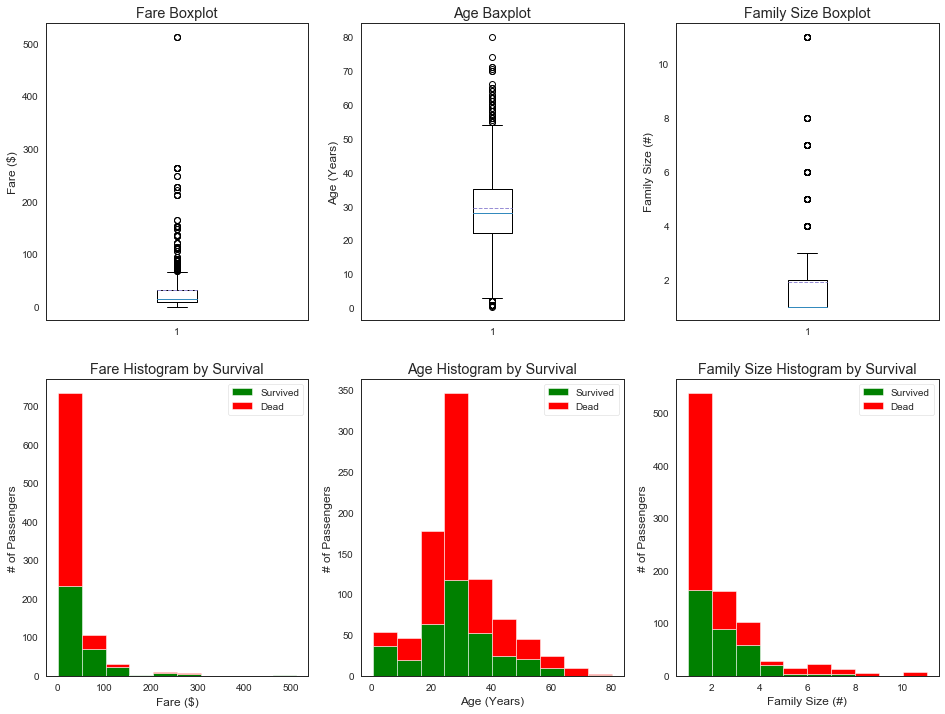

In [34]:
plt.figure(figsize = [16, 12])

plt.subplot(231)
plt.boxplot(x = data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Baxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived'] == 1]['Fare'],
              data1[data1['Survived'] == 0]['Fare']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived'] == 1]['Age'],
              data1[data1['Survived'] == 0]['Age']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived'] == 1]['FamilySize'],
              data1[data1['Survived'] == 0]['FamilySize']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

#### Embarked, IsAlone, FareBin과 Survived의 관계 Plotting

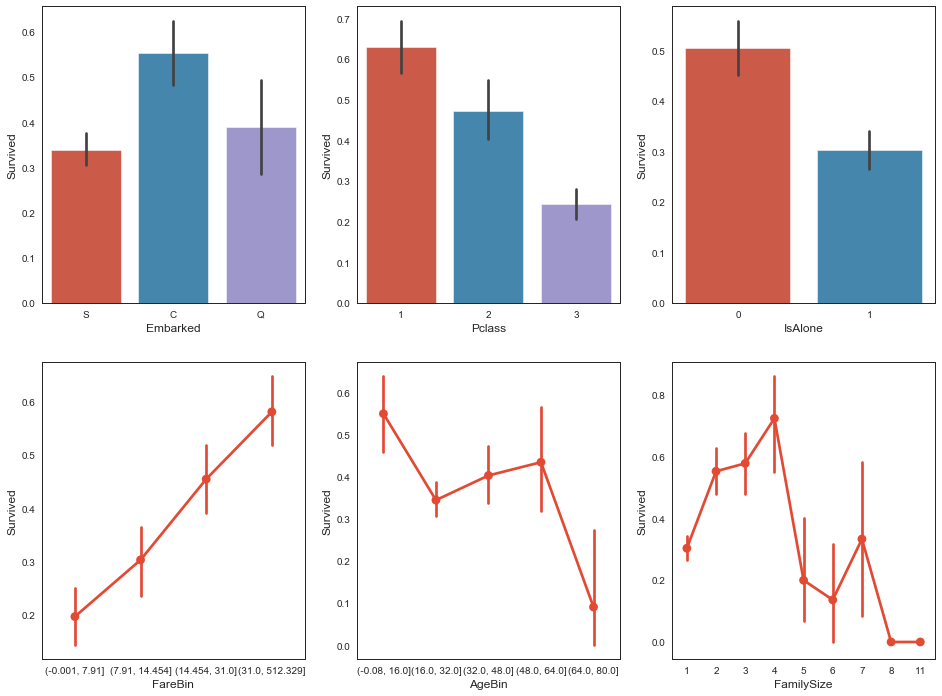

In [36]:
fig, saxis = plt.subplots(2, 3, figsize = (16, 12))

sns.barplot(x = 'Embarked', y = 'Survived',
            data = data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived',
            data = data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived',
            data = data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived', 
              data = data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',
              data = data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived',
              data = data1, ax = saxis[1,2])

#### Pclass와 Fare, Age, FamilySize사이의 관계파악

Text(0.5, 1.0, 'Pclass vs FamilySize Survival Comparison')

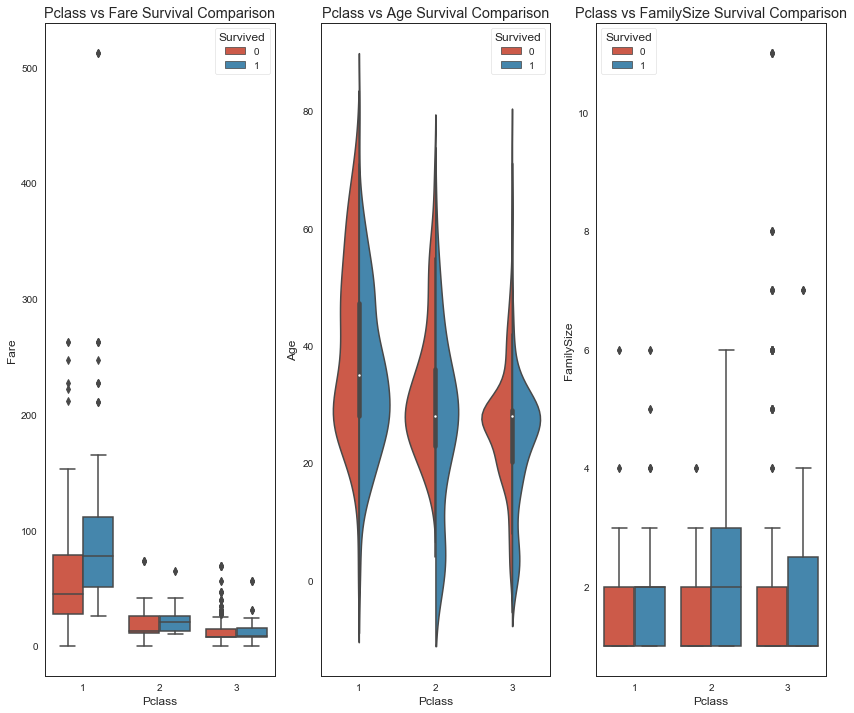

In [42]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (14, 12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived',
            data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived',
            data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y = 'FamilySize', hue = 'Survived',
            data = data1, ax =  axis3)
axis3.set_title('Pclass vs FamilySize Survival Comparison')


#### Sex와 Survival의 관계에서 Embarked, Pclass, IsAlone별로 나타내기

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

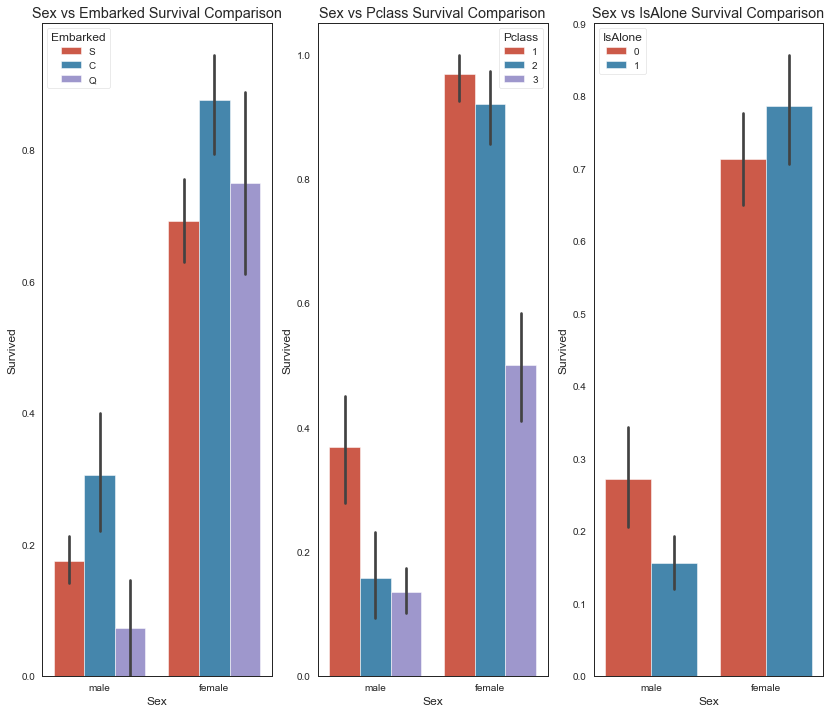

In [44]:
fig, qaxis = plt.subplots(1, 3, figsize = (14, 12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked',
            data = data1, ax = qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass',
            data = data1, ax= qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone',
            data =data1, ax = qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comparison')

#### Familysize, Pclass와 Survived사이의 관계에서 성별별로 나타내기

Text(0.5, 1.0, 'Pclass vs Sex Survived Comparison')

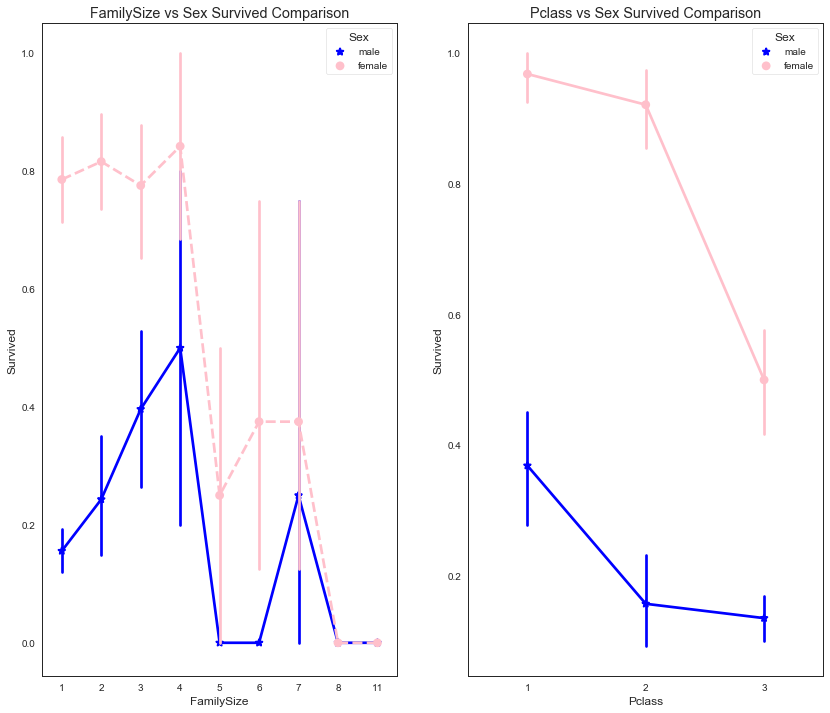

In [45]:
fig, (maxis1, maxis2) = plt.subplots(1, 2, figsize = (14, 12))

sns.pointplot(x = 'FamilySize', y = 'Survived', hue = 'Sex',
              data = data1, palette = {'male' : 'blue', 'female' : 'pink'},
              markers = ['*', 'o'], linestyles = ['-', '--'], ax = maxis1)
maxis1.set_title('FamilySize vs Sex Survived Comparison')

sns.pointplot(x = 'Pclass', y = 'Survived', hue = 'Sex',
              data = data1, palette = {'male' : 'blue', 'female' : 'pink'},
              markers = ['*', 'o'], linesytles = ['-', '--'], ax = maxis2)
maxis2.set_title('Pclass vs Sex Survived Comparison')

#### Embarked와 Pclass사이의 관계를 성별별로 나타내기

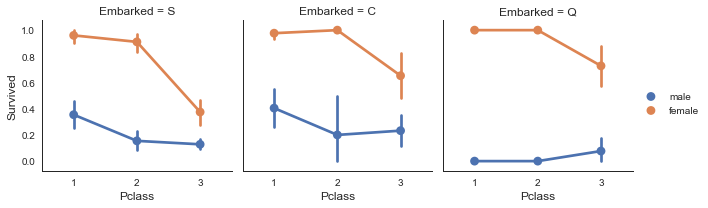

In [48]:
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', 
      ci = 95.0, palette = 'deep', hue_order = ['male', 'female'])
e.add_legend()

#### 나이별 생존자를 kdeplot으로 나타내기

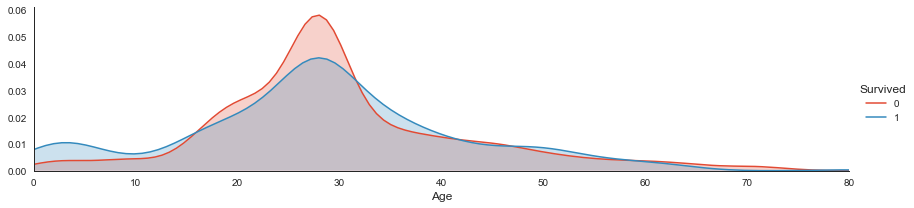

In [52]:
a = sns.FacetGrid(data1, hue = 'Survived', aspect = 4)
a.map(sns.kdeplot, 'Age', shade = True)
a.set(xlim = (0, data1['Age'].max()))
a.add_legend()

#### Sex, Pclass, Age별 생존자 비교

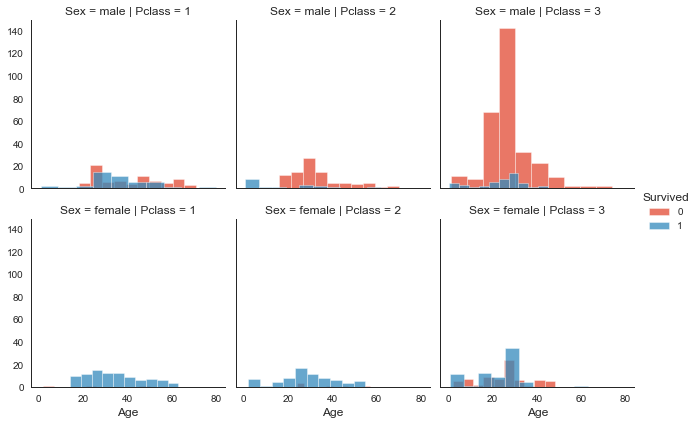

In [53]:
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

#### 전체 데이터셋에 대한 Pair Plot

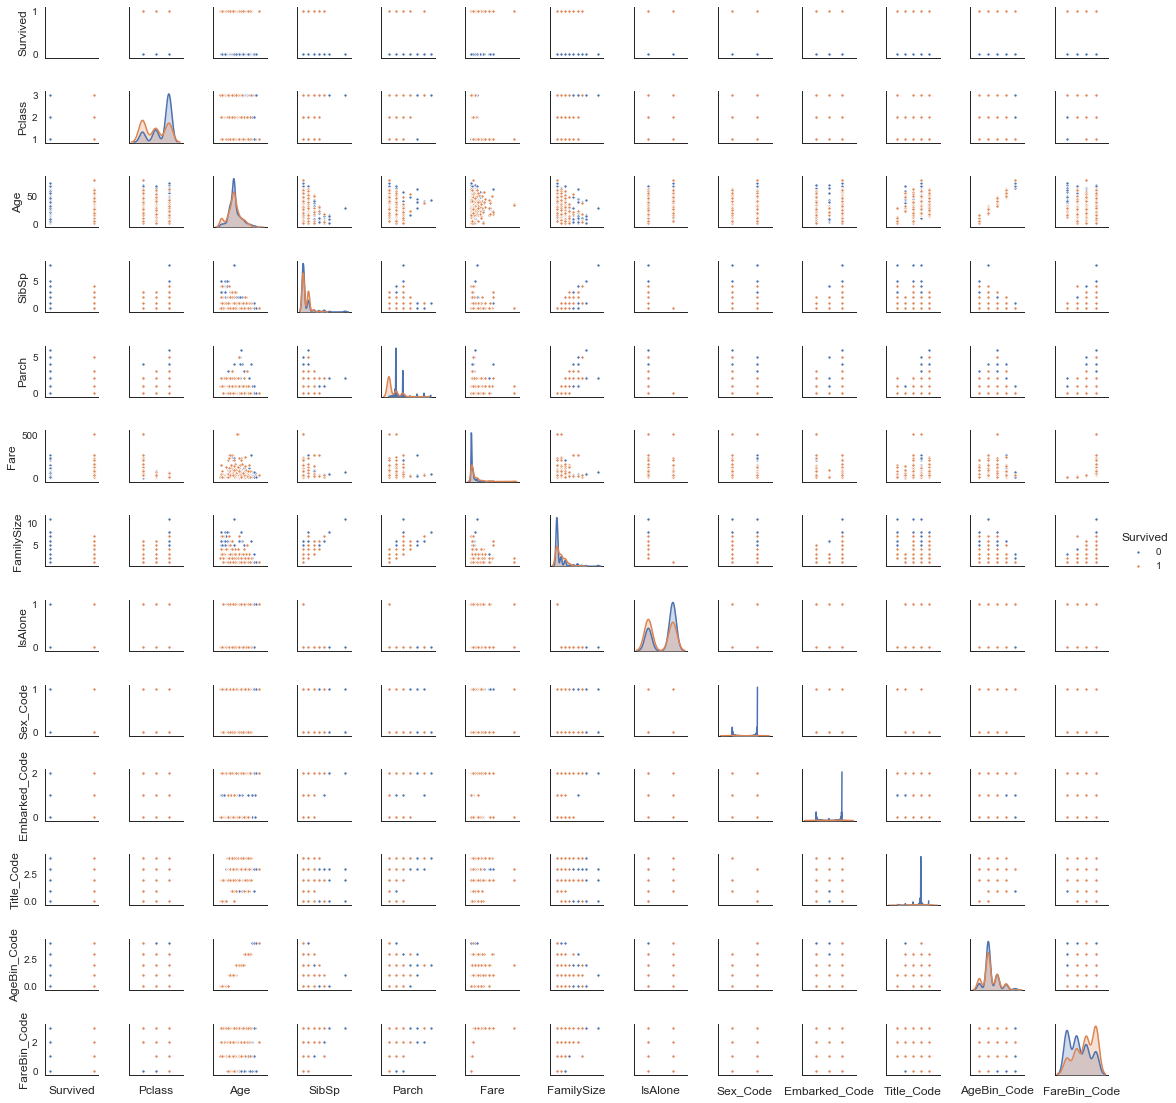

In [54]:
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep',
                  size = 1.2, diag_kind= 'kde', diag_kws = dict(shade = True),
                  plot_kws = dict(s = 10))
pp.set(xticklabels = [])

#### 데이터셋의 상관관계를 Heatmap으로 보기

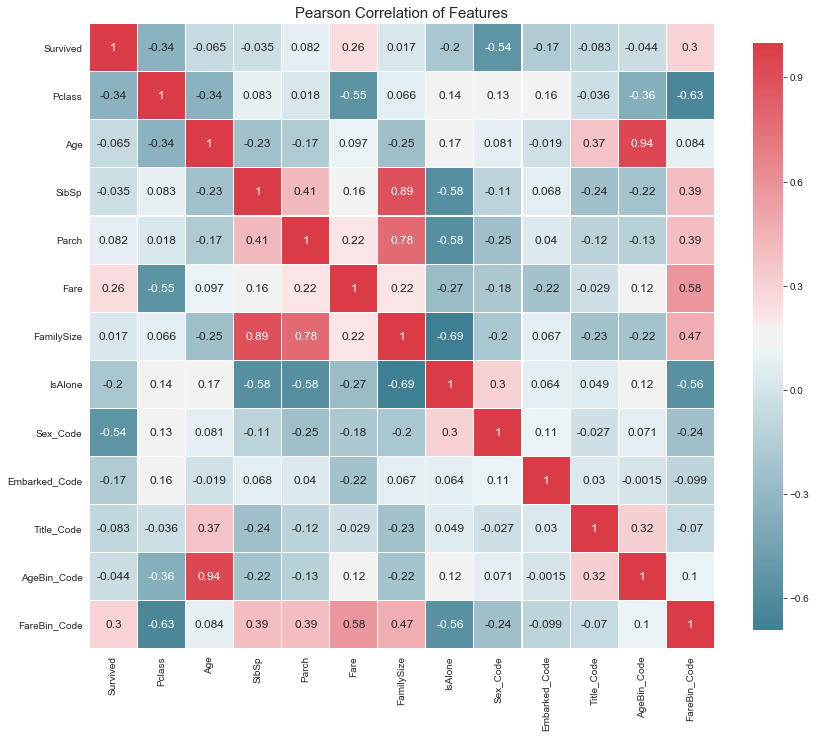

In [55]:
def correlation_heatmap(df) :
    _ , ax = plt.subplots(figsize = (14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square = True,
        cbar_kws = {'shrink' : .9},
        ax = ax,
        annot = True,
        linewidths = 0.1, vmax = 1.0, linecolor = 'white',
        annot_kws = {'fontsize' : 12}
    )
    
    plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
    
    
correlation_heatmap(data1)